In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

!pip install torch==1.12.1+cu116 torchvision==0.13.1+cu116 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu116
!pip install tqdm==4.65.0
!pip install Pillow==9.4.0
!pip install open3d==0.16.0
!git clone https://github.com/JonathonLuiten/diff-gaussian-rasterization-w-depth.git
%cd diff-gaussian-rasterization-w-depth
!python setup.py install
!pip install .

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
ERROR: Invalid requirement: 'tqdm=4.65.0'
Hint: = is not a valid operator. Did you mean == ?
fatal: destination path 'diff-gaussian-rasterization-w-depth' already exists and is not an empty directory.
/content/diff-gaussian-rasterization-w-depth
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        *******************************************

### Playing with RAFT

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision.models.optical_flow import raft_large, raft_small
from torchvision.utils import flow_to_image
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
of_model = raft_small(pretrained=True, progress=False).to(device)
of_model = of_model.eval()

frame_1 = torchvision.io.read_image('/content/gdrive/MyDrive/data/basketball/ims/0/000000.jpg')
frame_2 = torchvision.io.read_image('/content/gdrive/MyDrive/data/basketball/ims/0/000001.jpg')

def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
            T.Resize(size=(520, 960)),
        ]
    )
    batch = transforms(batch)
    return batch


# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

img1_batch = preprocess(frame_1).unsqueeze(dim=0).to(device)
img2_batch = preprocess(frame_2).unsqueeze(dim=0).to(device)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Raft_Small_Weights.C_T_V2`. You can also use `weights=Raft_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


shape = torch.Size([1, 3, 520, 960]), dtype = torch.float32


In [2]:
list_of_flows = of_model(image1=img1_batch, image2=img2_batch, num_flow_updates=24)
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

type = <class 'list'>
length = 24 = number of iterations of the model


In [3]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([1, 2, 520, 960]) = (N, 2, H, W)
min = -53.352760314941406, max = 18.530315399169922


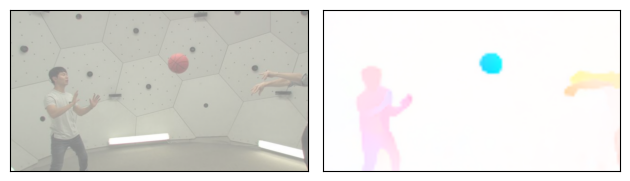

In [8]:
def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

## train

In [16]:
import torch
import os
import json
import copy
import numpy as np
from PIL import Image
from random import randint
from tqdm import tqdm
from diff_gaussian_rasterization import GaussianRasterizer as Renderer
from helpers import setup_camera, l1_loss_v1, l1_loss_v2, weighted_l2_loss_v1, weighted_l2_loss_v2, quat_mult, \
    o3d_knn, params2rendervar, params2cpu, save_params
from external import calc_ssim, calc_psnr, build_rotation, densify, update_params_and_optimizer

DATASET_PREFIX = '/content/gdrive/MyDrive'

def get_dataset(t, md, seq):
    dataset = []
    for c in range(len(md['fn'][t])):
        w, h, k, w2c = md['w'], md['h'], md['k'][t][c], md['w2c'][t][c]
        cam = setup_camera(w, h, k, w2c, near=1.0, far=100)
        fn = md['fn'][t][c]
        im = np.array(copy.deepcopy(Image.open(f"{DATASET_PREFIX}/data/{seq}/ims/{fn}")))
        im = torch.tensor(im).float().cuda().permute(2, 0, 1) / 255
        seg = np.array(copy.deepcopy(Image.open(f"{DATASET_PREFIX}/data/{seq}/seg/{fn.replace('.jpg', '.png')}"))).astype(np.float32)
        seg = torch.tensor(seg).float().cuda()
        seg_col = torch.stack((seg, torch.zeros_like(seg), 1 - seg))
        dataset.append({'cam': cam, 'im': im, 'seg': seg_col, 'id': c})
    return dataset


def get_batch(todo_dataset, dataset):
    if not todo_dataset:
        todo_dataset = dataset.copy()
    curr_data = todo_dataset.pop(randint(0, len(todo_dataset) - 1))
    return curr_data

def get_curr_and_prev_batch(todo_curr_dataset, todo_prev_dataset, curr_dataset, prev_dataset):
    if not todo_curr_dataset and not todo_prev_dataset:
        todo_curr_dataset = curr_dataset.copy()
        todo_prev_dataset = prev_dataset.copy()

    assert len(todo_curr_dataset) == len(todo_prev_dataset)
    index = randint(0, len(todo_curr_dataset) - 1)
    curr_data = todo_curr_dataset.pop(index)
    prev_data = todo_prev_dataset.pop(index)
    return curr_data, prev_data


def initialize_params(seq, md):
    init_pt_cld = np.load(f"{DATASET_PREFIX}/data/{seq}/init_pt_cld.npz")["data"]
    seg = init_pt_cld[:, 6]
    max_cams = 50
    sq_dist, _ = o3d_knn(init_pt_cld[:, :3], 3)
    mean3_sq_dist = sq_dist.mean(-1).clip(min=0.0000001)
    params = {
        'means3D': init_pt_cld[:, :3],
        'rgb_colors': init_pt_cld[:, 3:6],
        'seg_colors': np.stack((seg, np.zeros_like(seg), 1 - seg), -1),
        'unnorm_rotations': np.tile([1, 0, 0, 0], (seg.shape[0], 1)),
        'logit_opacities': np.zeros((seg.shape[0], 1)),
        'log_scales': np.tile(np.log(np.sqrt(mean3_sq_dist))[..., None], (1, 3)),
        'cam_m': np.zeros((max_cams, 3)),
        'cam_c': np.zeros((max_cams, 3)),
    }
    params = {k: torch.nn.Parameter(torch.tensor(v).cuda().float().contiguous().requires_grad_(True)) for k, v in
              params.items()}
    cam_centers = np.linalg.inv(md['w2c'][0])[:, :3, 3]  # Get scene radius
    scene_radius = 1.1 * np.max(np.linalg.norm(cam_centers - np.mean(cam_centers, 0)[None], axis=-1))
    variables = {'max_2D_radius': torch.zeros(params['means3D'].shape[0]).cuda().float(),
                 'scene_radius': scene_radius,
                 'means2D_gradient_accum': torch.zeros(params['means3D'].shape[0]).cuda().float(),
                 'denom': torch.zeros(params['means3D'].shape[0]).cuda().float()}
    return params, variables


def initialize_optimizer(params, variables):
    lrs = {
        'means3D': 0.00016 * variables['scene_radius'],
        'rgb_colors': 0.0025,
        'seg_colors': 0.0,
        'unnorm_rotations': 0.001,
        'logit_opacities': 0.05,
        'log_scales': 0.001,
        'cam_m': 1e-4,
        'cam_c': 1e-4,
    }
    param_groups = [{'params': [v], 'name': k, 'lr': lrs[k]} for k, v in params.items()]
    return torch.optim.Adam(param_groups, lr=0.0, eps=1e-15)

def _normalize_flow(flow):
  return (flow - flow.min()) / (flow.max() - flow.min())

def compute_of_seg_loss(of_model, rendered_im, curr_data, prev_data):
  processed_rendered_im = preprocess(rendered_im).unsqueeze(dim=0).to(device)
  processed_curr_im = preprocess(curr_data['im']).unsqueeze(dim=0).to(device)
  processed_prev_im = preprocess(prev_data['im']).unsqueeze(dim=0).to(device)
  flows_of_rendered = of_model(processed_prev_im, processed_rendered_im)[-1].squeeze()
  flows_of_curr     = of_model(processed_prev_im, processed_curr_im)[-1].squeeze()
  flow_im_rendered  = flow_to_image(flows_of_rendered)
  flow_im_curr      = flow_to_image(flows_of_curr)

  rendered_img_from_flow_image = F.to_pil_image(flow_im_rendered.to("cpu"))
  rendered_seg = F.to_grayscale(rendered_img_from_flow_image, num_output_channels=1)
  rendered_im_eg_tensor = F.to_tensor(rendered_seg)

  curr_img_from_flow_image = F.to_pil_image(flow_im_curr.to("cpu"))
  curr_seg = F.to_grayscale(curr_img_from_flow_image, num_output_channels=1)
  curr_im_seg_tensor = F.to_tensor(rendered_seg)
  return 0.8 * l1_loss_v1(flow_im_rendered.to(torch.float), flow_im_curr.to(torch.float)) + 0.2 * (1.0 - calc_ssim(flow_im_rendered.to(torch.float), flow_im_curr.to(torch.float)))


def calculate_epe(gt_flow, estimated_flow):
    """
    Calculate the Endpoint Error (EPE) between ground truth and estimated optical flow fields.

    Args:
        gt_flow (torch.Tensor): Ground truth optical flow, shape (batch_size, 2, height, width).
        estimated_flow (torch.Tensor): Estimated optical flow, shape (batch_size, 2, height, width).

    Returns:
        epe (torch.Tensor): EPE between the ground truth and estimated optical flow.
    """
    # Ensure the inputs have the same shape
    assert gt_flow.shape == estimated_flow.shape, "Input shapes must match."

    # Calculate the error vector (du, dv)
    error_vector = gt_flow - estimated_flow

    # Calculate the squared Euclidean distance
    squared_distance = torch.sum(error_vector**2, dim=1)

    # Take the square root to get the EPE
    epe = torch.sqrt(squared_distance)

    # Calculate the mean EPE across the entire batch
    epe = torch.mean(epe)

    return epe

def compute_optical_flow_loss(of_model, rendered_im, curr_data, prev_data):
  processed_rendered_im = preprocess(rendered_im).unsqueeze(dim=0).to(device)
  processed_curr_im = preprocess(curr_data['im']).unsqueeze(dim=0).to(device)
  processed_prev_im = preprocess(prev_data['im']).unsqueeze(dim=0).to(device)
  estimated_flow    = of_model(processed_prev_im, processed_rendered_im)[-1]
  gt_flow           = of_model(processed_prev_im, processed_curr_im)[-1]
  loss_fn           = calculate_epe(gt_flow=gt_flow, estimated_flow=estimated_flow)
  return loss_fn


def get_loss(of_model, params, curr_data, prev_data, variables, is_initial_timestep, i):
    losses = {}
    rendervar = params2rendervar(params)
    rendervar['means2D'].retain_grad()
    im, radius, _, = Renderer(raster_settings=curr_data['cam'])(**rendervar)
    curr_id = curr_data['id']
    im = torch.exp(params['cam_m'][curr_id])[:, None, None] * im + params['cam_c'][curr_id][:, None, None]
    losses['im'] = 0.8 * l1_loss_v1(im, curr_data['im']) + 0.2 * (1.0 - calc_ssim(im, curr_data['im']))
    variables['means2D'] = rendervar['means2D']  # Gradient only accum from colour render for densification

    segrendervar = params2rendervar(params)
    segrendervar['colors_precomp'] = params['seg_colors']
    seg, _, _, = Renderer(raster_settings=curr_data['cam'])(**segrendervar)

    # there is no optical flow at time step 0, therefore we rely on the segmentation masks
    if is_initial_timestep:
      losses['seg'] = 0.8 * l1_loss_v1(seg, curr_data['seg']) + 0.2 * (1.0 - calc_ssim(seg, curr_data['seg']))
    else:
      losses['optical_flow'] = compute_of_seg_loss(of_model, im, curr_data, prev_data)

    losses['seg'] = 0.8 * l1_loss_v1(seg, curr_data['seg']) + 0.2 * (1.0 - calc_ssim(seg, curr_data['seg']))

    if not is_initial_timestep:
        is_fg = (params['seg_colors'][:, 0] > 0.5).detach()
        fg_pts = rendervar['means3D'][is_fg]
        fg_rot = rendervar['rotations'][is_fg]

        rel_rot = quat_mult(fg_rot, variables["prev_inv_rot_fg"])
        rot = build_rotation(rel_rot)
        neighbor_pts = fg_pts[variables["neighbor_indices"]]
        curr_offset = neighbor_pts - fg_pts[:, None]
        curr_offset_in_prev_coord = (rot.transpose(2, 1)[:, None] @ curr_offset[:, :, :, None]).squeeze(-1)
        losses['rigid'] = weighted_l2_loss_v2(curr_offset_in_prev_coord, variables["prev_offset"],
                                              variables["neighbor_weight"])

        losses['rot'] = weighted_l2_loss_v2(rel_rot[variables["neighbor_indices"]], rel_rot[:, None],
                                            variables["neighbor_weight"])

        curr_offset_mag = torch.sqrt((curr_offset ** 2).sum(-1) + 1e-20)
        losses['iso'] = weighted_l2_loss_v1(curr_offset_mag, variables["neighbor_dist"], variables["neighbor_weight"])

        losses['floor'] = torch.clamp(fg_pts[:, 1], min=0).mean()

        bg_pts = rendervar['means3D'][~is_fg]
        bg_rot = rendervar['rotations'][~is_fg]
        losses['bg'] = l1_loss_v2(bg_pts, variables["init_bg_pts"]) + l1_loss_v2(bg_rot, variables["init_bg_rot"])

        losses['soft_col_cons'] = l1_loss_v2(params['rgb_colors'], variables["prev_col"])
        #losses['optical_flow']  = compute_optical_flow_loss(of_model, im, curr_data, prev_data)

    loss_weights = {'im': 1.0, 'rigid': 4.0, 'rot': 4.0, 'iso': 2.0, 'floor': 2.0, 'bg': 20.0,
                    'soft_col_cons': 0.01, 'seg': 3.0, 'optical_flow': 3.0}
    loss = sum([loss_weights[k] * v for k, v in losses.items()])
    seen = radius > 0
    variables['max_2D_radius'][seen] = torch.max(radius[seen], variables['max_2D_radius'][seen])
    variables['seen'] = seen
    return loss, variables


def initialize_per_timestep(params, variables, optimizer):
    pts = params['means3D']
    rot = torch.nn.functional.normalize(params['unnorm_rotations'])
    new_pts = pts + (pts - variables["prev_pts"])
    new_rot = torch.nn.functional.normalize(rot + (rot - variables["prev_rot"]))

    is_fg = params['seg_colors'][:, 0] > 0.5
    prev_inv_rot_fg = rot[is_fg]
    prev_inv_rot_fg[:, 1:] = -1 * prev_inv_rot_fg[:, 1:]
    fg_pts = pts[is_fg]
    prev_offset = fg_pts[variables["neighbor_indices"]] - fg_pts[:, None]
    variables['prev_inv_rot_fg'] = prev_inv_rot_fg.detach()
    variables['prev_offset'] = prev_offset.detach()
    variables["prev_col"] = params['rgb_colors'].detach()
    variables["prev_pts"] = pts.detach()
    variables["prev_rot"] = rot.detach()

    new_params = {'means3D': new_pts, 'unnorm_rotations': new_rot}
    params = update_params_and_optimizer(new_params, params, optimizer)

    return params, variables


def initialize_post_first_timestep(params, variables, optimizer, num_knn=20):
    is_fg = params['seg_colors'][:, 0] > 0.5
    init_fg_pts = params['means3D'][is_fg]
    init_bg_pts = params['means3D'][~is_fg]
    init_bg_rot = torch.nn.functional.normalize(params['unnorm_rotations'][~is_fg])
    neighbor_sq_dist, neighbor_indices = o3d_knn(init_fg_pts.detach().cpu().numpy(), num_knn)
    neighbor_weight = np.exp(-2000 * neighbor_sq_dist)
    neighbor_dist = np.sqrt(neighbor_sq_dist)
    variables["neighbor_indices"] = torch.tensor(neighbor_indices).cuda().long().contiguous()
    variables["neighbor_weight"] = torch.tensor(neighbor_weight).cuda().float().contiguous()
    variables["neighbor_dist"] = torch.tensor(neighbor_dist).cuda().float().contiguous()

    variables["init_bg_pts"] = init_bg_pts.detach()
    variables["init_bg_rot"] = init_bg_rot.detach()
    variables["prev_pts"] = params['means3D'].detach()
    variables["prev_rot"] = torch.nn.functional.normalize(params['unnorm_rotations']).detach()
    params_to_fix = ['logit_opacities', 'log_scales', 'cam_m', 'cam_c']
    for param_group in optimizer.param_groups:
        if param_group["name"] in params_to_fix:
            param_group['lr'] = 0.0
    return variables


def report_progress(params, data, i, progress_bar, every_i=100):
    if i % every_i == 0:
        im, _, _, = Renderer(raster_settings=data['cam'])(**params2rendervar(params))
        curr_id = data['id']
        im = torch.exp(params['cam_m'][curr_id])[:, None, None] * im + params['cam_c'][curr_id][:, None, None]
        psnr = calc_psnr(im, data['im']).mean()
        progress_bar.set_postfix({"train img 0 PSNR": f"{psnr:.{7}f}"})
        progress_bar.update(every_i)


def train(seq, exp):
    if os.path.exists(f"./output/{exp}/{seq}"):
        print(f"Experiment '{exp}' for sequence '{seq}' already exists. Exiting.")
        return
    print("Preparing training variables")
    md = json.load(open(f"{DATASET_PREFIX}/data/{seq}/train_meta.json", 'r'))  # metadata
    num_timesteps = len(md['fn'])
    params, variables = initialize_params(seq, md)
    optimizer = initialize_optimizer(params, variables)
    output_params = []
    prev_data = None  #testing OF idea
    print("Initating Training")
    for t in range(num_timesteps):
        curr_dataset = get_dataset(t, md, seq)
        todo_curr_dataset = []
        todo_prev_dataset = []
        prev_dataset = None if t == 0 else get_dataset(t - 1, md, seq)
        is_initial_timestep = (t == 0)
        if not is_initial_timestep:
            params, variables = initialize_per_timestep(params, variables, optimizer)
        num_iter_per_timestep = 10000 if is_initial_timestep else 2000
        progress_bar = tqdm(range(num_iter_per_timestep), desc=f"timestep {t}")
        for i in range(num_iter_per_timestep):
            if is_initial_timestep:
                curr_data = get_batch(todo_curr_dataset, curr_dataset)
                prev_data = None
            else:
                prev_data, curr_data = get_curr_and_prev_batch(todo_curr_dataset, todo_prev_dataset, curr_dataset, prev_dataset)
            loss, variables = get_loss(of_model, params, curr_data, prev_data, variables, is_initial_timestep, i)
            loss.backward()
            with torch.no_grad():
                report_progress(params, curr_dataset[0], i, progress_bar)
                if is_initial_timestep:
                    params, variables = densify(params, variables, optimizer, i)
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
        progress_bar.close()
        output_params.append(params2cpu(params, is_initial_timestep))
        if is_initial_timestep:
            variables = initialize_post_first_timestep(params, variables, optimizer)
    save_params(output_params, seq, exp)

In [ ]:
exp_name = 'exp0'
for sequence in ["basketball", "boxes", "football", "juggle", "softball", "tennis"]:
    train(sequence, exp_name)
    torch.cuda.empty_cache()

Preparing training variables
Initating Training


timestep 1:  55%|█████▌    | 1100/2000 [02:33<02:17,  6.56it/s, train img 0 PSNR=28.6460571]